In [188]:
import numpy as np
import mne
from mne import preprocessing

from scipy import signal

import matplotlib.pyplot as plt

from libci import utils

import pyxdf

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd

from sklearn.decomposition import PCA
from joblib import delayed, Parallel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
from sklearn.utils import check_X_y

class FLD:
    def __init__(self, priors=None, zero_intersection=True):
        self.is_fitted=False
        self.zero_intersection = zero_intersection
        
        self.priors_=priors
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.classes_, counts = np.unique(y, return_counts=True)
        
        if self.priors_ is None:
            self.priors_ = counts / len(y)
        
        if len(self.classes_) != 2:
            raise ValueError("only two class classification implemented")
        self.inds = [np.where(y == c)[0] for c in self.classes_]
        
        self.means_ = np.array([np.mean(X[inds], axis=0) for inds in self.inds])
        if self.zero_intersection:
            mid_point = 0.5 * (self.means_[0] + self.means_[1])
            self.means_ = np.array([m - mid_point for m in self.means_])
        
        self.covs_ = np.array([np.cov(X[inds].T) for inds in self.inds])
        
        self.projection_ = np.linalg.pinv(np.sum(self.covs_, axis=0))
        self.projection_ = self.projection_ @ (self.means_[0] - self.means_[1])
        
        self.threshold = np.dot(self.projection_, self.means_[0]) + np.dot(self.projection_, self.means_[1])
        self.threshold /= 2
        
        self.is_fitted=True
        
        return self
    
    def predict(self, X):
        projected = X @ self.projection_
        
        return (projected < self.threshold).astype(int)

In [190]:
dir_ = '/home/azureuser/physionet.org/files/eegmat/1.0.0/'

meta = pd.read_csv(dir_ + 'subject-info.csv')
meta.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [191]:
subject_labels = np.array(list(meta['Count quality']))
gender = np.array(list(meta['Gender']))
recording_year = np.array(list(meta['Recording year']))

raw_edfs = utils.get_raw_edfs(dir_)

raw_edfs = [r.drop_channels(['ECG ECG', 'EEG A2-A1']) for r in raw_edfs]
raw_edfs = [r.rename_channels(lambda x: x.split(' ')[-1]) for r in raw_edfs]
    
montage = mne.channels.make_standard_montage(kind='standard_1020')

infos = [r.set_montage(montage, on_missing='ignore') for r in raw_edfs]
infos = [r.copy().set_eeg_reference(ref_channels='average') for r in infos]
infos = [r.filter(0.5, 30) for r in infos]

In [302]:
np.random.seed(1)

# n_components = 18

# ica = preprocessing.ICA(n_components=n_components, max_iter=1000)
# ica.fit(infos[0])

# ica.plot_properties(infos[0], picks=np.arange(n_components), verbose=False)

# ica.exclude = [4,9,10,14,15,17]
# postica = [ica.apply(i.load_data(verbose=False), verbose=False, exclude=ica.exclude).get_data() for i in infos]

channel_inds = np.array([0,1,2,3])

nspw=2.5
windowed = utils.get_time_windows([r.get_data()[channel_inds] for r in infos], sfreq=500, n_seconds_per_window=nspw, n_seconds_overlap=0)

bands = [[4,8], [8,12], [12,20]]
psd = utils.get_power_spectrum_ratio(windowed, 500, bands)
psd = [p / np.sum(p, axis=-1, keepdims=True) for p in psd]

concat = utils.concatenate_features(psd, axes=[-2,-1])
concat = [c / np.sum(c, axis=-1, keepdims=True) for c in concat]

X = [np.concatenate((concat[i], concat[i+1])) for i in range(0, len(concat), 2)]
labels_by_person = [i*np.ones(bp.shape[0]) for i, bp in enumerate(X)]
y = [np.concatenate((i * np.ones(concat[i].shape[0]), (i+1) * np.ones(concat[i+1].shape[0]))) for i in range(0, len(concat), 2)]

y_by_session = [i*np.ones(bp.shape[0]) for i, bp in enumerate(concat)]

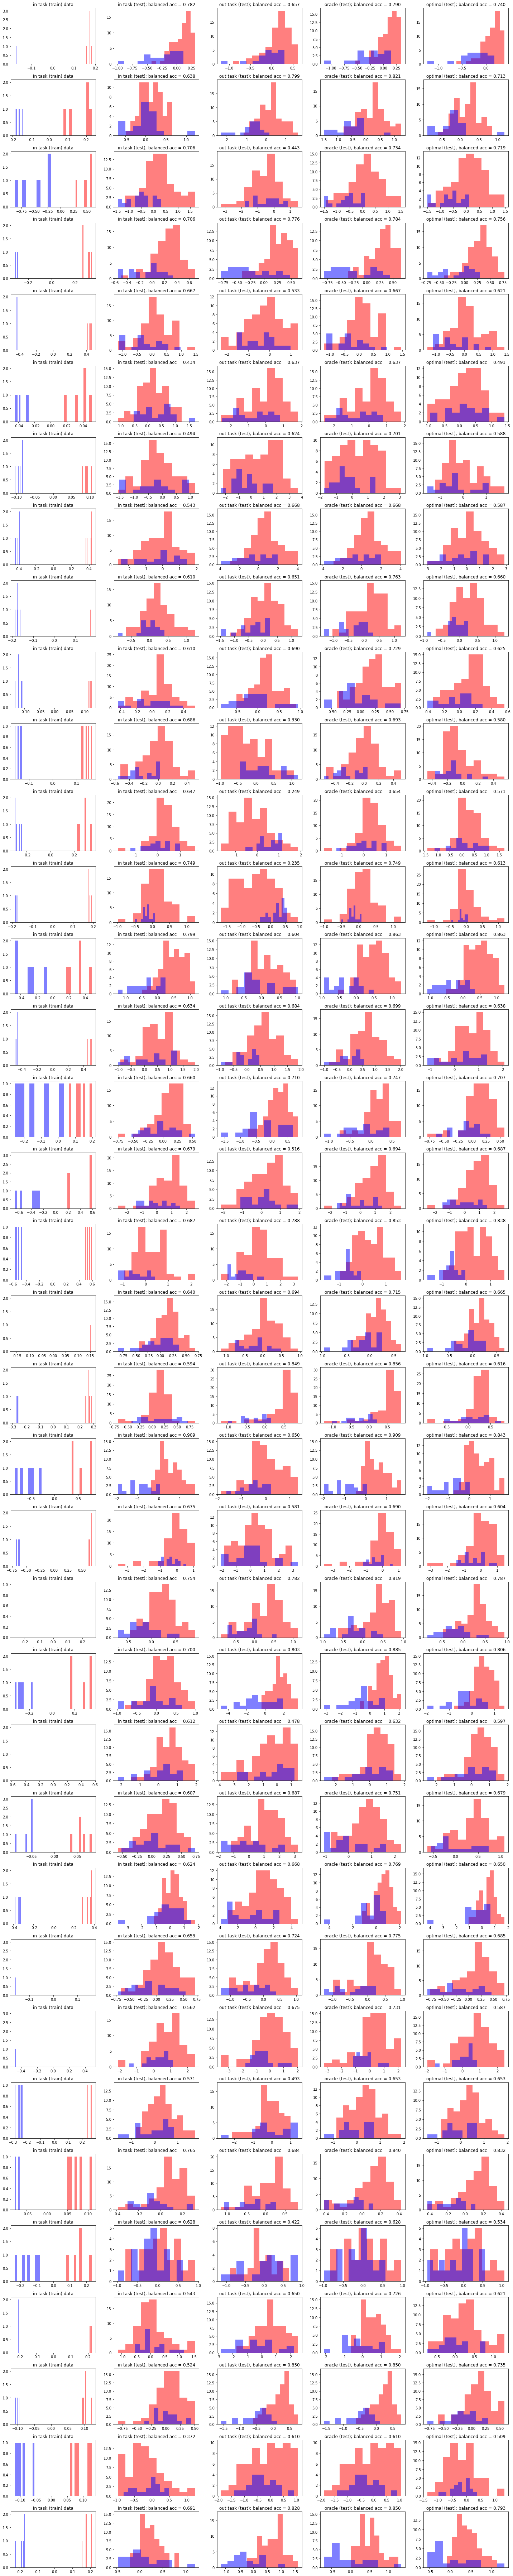

In [365]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tfld.tfld import FLD, TranslateStandardScale
from sklearn.metrics import balanced_accuracy_score as bas


fig, ax = plt.subplots(len(X),5, figsize=(20, 100))

projs = []

accuracies = np.zeros((len(X), 4))

seed=1

p=0.2
for i in range(len(X)):
    np.random.seed(seed)
    
    train = tfld.even_sample_inds(y_[i], p=p)
        
    xx = X[i][train]
    yy = y_[i][train]
    
    tss = TranslateStandardScale()
    tss.fit_transform(xx, yy)
    
    t = tss.transform(xx)
    
    fld = FLD().fit(t, yy)
    proj = fld.projection_
    
    projs.append(proj)
    
    
bacc_diffs = np.zeros(len(X))
for i in range(len(X)):
    combined_proj = np.sum([p for j,p in enumerate(projs) if j!=i ], axis=0)
    combined_proj /= np.linalg.norm(combined_proj)
    
    np.random.seed(seed)
    
    train = tfld.even_sample_inds(y_[i], p=p)
        
    xx = X[i][train]
    yy = y_[i][train]
    
    tss = TranslateStandardScale()
    tss.fit_transform(xx, yy)
    
    t = tss.transform(xx)    
    t2 = t @ projs[i]
    
    ax[i,0].hist(t2[yy == 0], color='r', alpha=0.5)
    ax[i,0].hist(t2[yy == 1], color='b', alpha=0.5)
    
    ax[i,0].set_title('in task (train) data')
    
    test = np.array([i for i in range(len(X[i])) if i not in train])
    xx = X[i][test]
    yy = y_[i][test]
    
    t = tss.transform(xx)
    t2 = t @ projs[i]
    
    ax[i,1].hist(t2[yy == 0], color='r', alpha=0.5)
    ax[i,1].hist(t2[yy == 1], color='b', alpha=0.5)
    
    preds = (t2 < 0).astype(int)
    in_bacc = bas(yy, preds)
    ax[i,1].set_title('in task (test); balanced acc = %1.3f'%(in_bacc))
    accuracies[i,0] = in_bacc
    
    t = tss.transform(xx)
    t2 = t @ combined_proj
    
    ax[i,2].hist(t2[yy == 0], color='r', alpha=0.5)
    ax[i,2].hist(t2[yy == 1], color='b', alpha=0.5)
    
    preds = (t2 < 0).astype(int)
    comb_bacc = bas(yy, preds)
    accuracies[i,1] = comb_bacc
    ax[i,2].set_title('out task (test); balanced acc = %1.3f'%(comb_bacc))
    
    alpha_grid = np.arange(0,1.01, 0.01)
    
    oracle_bacc = 0
    for j, alpha in enumerate(alpha_grid):
        temp_proj = alpha * projs[i] + (1 - alpha) * combined_proj
        temp_proj /= np.linalg.norm(temp_proj)
        
        t2 = t @ temp_proj
        
        preds = (t2 < 0).astype(int)
        temp_bacc = bas(yy, preds)
        
        if temp_bacc > oracle_bacc:
            oracle_bacc = temp_bacc
            alpha_oracle = alpha
    
    proj_oracle = alpha_oracle * projs[i] + (1 - alpha_oracle) * combined_proj
    proj_oracle /= np.linalg.norm(proj_oracle)
    
    accuracies[i,2] = oracle_bacc
    
    t2 = t @ proj_oracle
    ax[i,3].hist(t2[yy == 0], color='r', alpha=0.5)
    ax[i,3].hist(t2[yy == 1], color='b', alpha=0.5)
    ax[i,3].set_title('oracle (test); balanced acc = %1.3f'%(oracle_bacc))
    
    
#     n_vector = [len(train) for i in range(len(X))]
    
#     temp_projs = projs[i] + [proj for j, proj in enumerate(projs) if j !=i]
    alpha_optimal = optimal_alphas[i]
    
    proj_optimal = alpha_optimal * projs[i] + (1 - alpha_optimal) * combined_proj
    proj_optimal /= np.linalg.norm(proj_optimal)
    
    
    t2 = t @ proj_optimal
        
    preds = (t2 < 0).astype(int)
    optimal_bacc = bas(yy, preds)
    accuracies[i,3] = optimal_bacc
    ax[i,4].hist(t2[yy == 0], color='r', alpha=0.5)
    ax[i,4].hist(t2[yy == 1], color='b', alpha=0.5)
    ax[i,4].set_title('optimal (test); balanced acc = %1.3f'%(optimal_bacc))    
    
    
        
        
plt.tight_layout()
# plt.savefig('single_task_and_combined_and_oracle_histograms.png')

In [366]:
np.mean(accuracies, axis=0)

array([0.64313501, 0.63111071, 0.74819174, 0.67205678])

In [364]:
optimal_alphas = np.zeros(len(X))

for i in range(len(X)):
    np.random.seed(seed)
    
    train = tfld.even_sample_inds(y_[i], p=p)

    n_vector = [len(train) for i in range(len(X))]
    
    temp_projs = [projs[i]] + [proj for j, proj in enumerate(projs) if j !=i]
    alpha_optimal = tfld.get_optimal_alpha(n_vector, temp_projs, n_samples_to_estimate_risk=300, n_jobs=30)
    
    optimal_alphas[i] = alpha_optimal

    print(i, alpha_optimal)

0.0 0.495708927496122
0.01 0.4884662455644721
0.02 0.4935784570078685
0.03 0.49042453071918335
0.04 0.48009025764724866
0.05 0.4812597978572751
0.06 0.4809040994897995
0.07 0.476881824547146
0.08 0.4712748282536903
0.09 0.47221725794251646
0.1 0.46063018053174903
0.11 0.46058360096845063
0.12 0.45852350179146467
0.13 0.44655062915329136
0.14 0.4527454458357139
0.15 0.4424181919838897
0.16 0.45344458174677127
0.17 0.43380657754173435
0.18 0.4333419319517865
0.19 0.4321038027244925
0.2 0.4197168830009456
0.21 0.42368753002014087
0.22 0.4104935458003798
0.23 0.4098570590637164
0.24 0.4048554961464512
0.25 0.40523831216892275
0.26 0.39437635685626804
0.27 0.3937928946268901
0.28 0.39239387394242936
0.29 0.38617444003407986
0.3 0.37892136768078016
0.31 0.3750180467385117
0.32 0.37445470178972046
0.33 0.3673279844598877
0.34 0.3609579958637919
0.35000000000000003 0.35580621802122286
0.36 0.3493494569041661
0.37 0.34654054724781
0.38 0.34278347992453
0.39 0.3341361104538383
0.4 0.324233976189

0.16 0.38552612034459527
0.17 0.36744497330749726
0.18 0.36010930756642456
0.19 0.3693751441071585
0.2 0.3550511264365915
0.21 0.3575686507591777
0.22 0.3624105760640234
0.23 0.348451495936518
0.24 0.34260589673078384
0.25 0.34593951325406286
0.26 0.33974274518350406
0.27 0.33525942121606694
0.28 0.33442778395300077
0.29 0.3352335232289837
0.3 0.3268456323686182
0.31 0.3182977542453751
0.32 0.318245799620721
0.33 0.31706450526045465
0.34 0.3093355915352274
0.35000000000000003 0.3046850954369665
0.36 0.3034557717473665
0.37 0.30205013545150294
0.38 0.3032679522145881
0.39 0.29783820941881667
0.4 0.2914129890608336
0.41000000000000003 0.29014638113013336
0.42 0.28985888130249443
0.43 0.2830297938052262
0.44 0.27817401699920813
0.45 0.2779282576058477
0.46 0.2736194776754968
0.47000000000000003 0.2733668345450606
0.48 0.26962155377104075
0.49 0.2616069080957446
0.5 0.2624640128903998
0.51 0.2582641550025726
0.52 0.2580233450583337
0.53 0.2548962252752704
0.54 0.25605974698543005
0.55 0.25

0.31 0.3179651716568635
0.32 0.31064844260149266
0.33 0.3080812227653912
0.34 0.30397142442527286
0.35000000000000003 0.3021852520091949
0.36 0.29844638843852694
0.37 0.29708736255003854
0.38 0.2895697495413546
0.39 0.28877740863557333
0.4 0.28526656376793846
0.41000000000000003 0.2863404903011417
0.42 0.274926324018699
0.43 0.2798006271880707
0.44 0.27824846227861305
0.45 0.27576810469327223
0.46 0.2710634486655206
0.47000000000000003 0.2647116296077884
0.48 0.2616873080166737
0.49 0.26432506209429013
0.5 0.2642261216734836
0.51 0.26060088464244974
0.52 0.25783744331066105
0.53 0.2587503261730302
0.54 0.2501042838461156
0.55 0.2471869354980692
0.56 0.2513611936641146
0.5700000000000001 0.25035769331002367
0.58 0.25095884270005564
0.59 0.244252454284523
0.6 0.2426711643019242
0.61 0.24535328481065055
0.62 0.2442608133840056
0.63 0.23880713549000002
0.64 0.24002645093054387
0.65 0.2401263020877903
0.66 0.23558255881799445
0.67 0.23578007132097
0.68 0.23550139484983476
0.6900000000000001

0.44 0.316237865885302
0.45 0.31674018164492546
0.46 0.30656509723489955
0.47000000000000003 0.2994221827798279
0.48 0.2999823382097488
0.49 0.2920191254935061
0.5 0.29027026290361446
0.51 0.2856063899187076
0.52 0.2841259887895796
0.53 0.2778508865779726
0.54 0.277806716738667
0.55 0.27172187871296927
0.56 0.265235843181461
0.5700000000000001 0.262842019385407
0.58 0.26521601483945123
0.59 0.26024365347749795
0.6 0.25551643237481253
0.61 0.2538075440603145
0.62 0.2483151229466469
0.63 0.2505477887173625
0.64 0.2486018610125489
0.65 0.24965934407774565
0.66 0.24438517615929925
0.67 0.2439510181484956
0.68 0.24206538138148545
0.6900000000000001 0.24117954612566356
0.7000000000000001 0.2427522329345277
0.71 0.23899768541965075
0.72 0.2368593790223521
0.73 0.238793931618907
0.74 0.23732663220143366
0.75 0.23972375558397574
0.76 0.23973829638960703
0.77 0.23525065318792523
0.78 0.23826507864652968
0.79 0.2367452173630168
0.8 0.2350845432234117
0.81 0.24034938262328434
0.8200000000000001 0.

0.59 0.2793302445924974
0.6 0.2732043277063418
0.61 0.2663013265544323
0.62 0.26285746976553764
0.63 0.26095302607991044
0.64 0.25499941802367
0.65 0.2532430683385698
0.66 0.25013067053720667
0.67 0.25135242817258996
0.68 0.2505864723939961
0.6900000000000001 0.2428629109348314
0.7000000000000001 0.24524704964203048
0.71 0.24211640738132284
0.72 0.2396218169850245
0.73 0.24312448787308105
0.74 0.24151206060452865
0.75 0.2398332871484232
0.76 0.24501461380499695
0.77 0.23881543127652377
0.78 0.23843744386983948
0.79 0.2388073714833735
0.8 0.23286742566374585
0.81 0.23103118142506346
0.8200000000000001 0.23762340638398485
0.8300000000000001 0.23665099781725213
0.84 0.23604766858143808
0.85 0.24214507076335234
0.86 0.23870501364847974
0.87 0.23721505388563546
0.88 0.23773045893636624
0.89 0.23672307473341395
0.9 0.2367136378470426
0.91 0.23824779327772844
0.92 0.2472646015845472
0.93 0.24365692854094884
0.9400000000000001 0.2450478974166674
0.9500000000000001 0.24277663922448955
0.96 0.24

0.74 0.2336814401648889
0.75 0.23281732208165096
0.76 0.23487136240108053
0.77 0.2282154969944702
0.78 0.23330697694590516
0.79 0.23225998072395895
0.8 0.23348727699939795
0.81 0.23608661029002495
0.8200000000000001 0.23244818962660507
0.8300000000000001 0.23083939263127437
0.84 0.23399493580201314
0.85 0.23785549509559872
0.86 0.233782695843986
0.87 0.23573800360938427
0.88 0.24062567538701377
0.89 0.2368450594608061
0.9 0.23731287421963393
0.91 0.23927643151643072
0.92 0.24845915050445871
0.93 0.24434112816729006
0.9400000000000001 0.24344496216348438
0.9500000000000001 0.24592158374314066
0.96 0.24484386958965493
0.97 0.25033017213921727
0.98 0.25111236235218265
0.99 0.25106186548791765
1.0 0.2496124072084748
15 0.77
0.0 0.45680454212710647
0.01 0.4575514415519816
0.02 0.44964510540238356
0.03 0.45004650400257673
0.04 0.4531784590865945
0.05 0.4451277153228425
0.06 0.4432650914729291
0.07 0.433969646019345
0.08 0.43902486763511317
0.09 0.4326488920387364
0.1 0.42919244532809503
0.11

0.87 0.23545510189657592
0.88 0.24015516848794866
0.89 0.2363563383758273
0.9 0.23709140501750592
0.91 0.2403070557497434
0.92 0.25204158277731425
0.93 0.24486752149367386
0.9400000000000001 0.24209920886252728
0.9500000000000001 0.24701305017550074
0.96 0.24609830038350036
0.97 0.2528816175703678
0.98 0.2510300150559828
0.99 0.24934385482363713
1.0 0.25111125093601844
18 0.8300000000000001
0.0 0.49284684015081853
0.01 0.48723096558446316
0.02 0.4827038878717104
0.03 0.47437501520876085
0.04 0.4698849115348794
0.05 0.484259779383075
0.06 0.47423129595167857
0.07 0.46859584989655767
0.08 0.4703353652213439
0.09 0.4656155402963801
0.1 0.4680893110247661
0.11 0.4615781752198696
0.12 0.4455577498058748
0.13 0.4405953528826792
0.14 0.45087384786113016
0.15 0.43800139810307237
0.16 0.43729516174178606
0.17 0.43377176215208235
0.18 0.43568832493775006
0.19 0.41909797956280975
0.2 0.42142495448468914
0.21 0.4197825661812569
0.22 0.39918778942277705
0.23 0.4078369640256129
0.24 0.40376283918793

1.0 0.25389740419390594
21 0.8
0.0 0.4829759868065649
0.01 0.4743575953171481
0.02 0.47487245020094443
0.03 0.4762187922602696
0.04 0.4632733675785166
0.05 0.47453732526805187
0.06 0.4647120343471216
0.07 0.4598236965941186
0.08 0.45933143091219186
0.09 0.4556114173253171
0.1 0.46474052296070634
0.11 0.45031972323503067
0.12 0.44220294765096896
0.13 0.42930088144619255
0.14 0.4404803844029836
0.15 0.43067398638649007
0.16 0.4313846795429823
0.17 0.42661205222290977
0.18 0.4217389813559143
0.19 0.4134217306083639
0.2 0.4135750701517805
0.21 0.40999688181206806
0.22 0.4013966178546125
0.23 0.4003979050871777
0.24 0.39345315940882536
0.25 0.3859225152376106
0.26 0.3840455692736223
0.27 0.38825384949557673
0.28 0.37671255549570437
0.29 0.37259269486564817
0.3 0.3657342903494495
0.31 0.36677043122886116
0.32 0.3632279545614038
0.33 0.35077413291954346
0.34 0.34510655591619377
0.35000000000000003 0.3436751888147084
0.36 0.34266571709526145
0.37 0.33961914981906016
0.38 0.3276788579282527
0.3

0.14 0.40395529302927724
0.15 0.4082457152648811
0.16 0.38884334226376144
0.17 0.3983907522130507
0.18 0.3931558344219548
0.19 0.3865650278437689
0.2 0.39292255559486583
0.21 0.3826010754577261
0.22 0.3777311855366824
0.23 0.3740920086453574
0.24 0.370466945198292
0.25 0.36407090072313053
0.26 0.3603712198152931
0.27 0.3559357882781065
0.28 0.35047742160379186
0.29 0.3448087593758204
0.3 0.34265773159414037
0.31 0.3412545568713352
0.32 0.3346349553349269
0.33 0.33061222710035215
0.34 0.3219772770532772
0.35000000000000003 0.32285706703589323
0.36 0.3216340309029991
0.37 0.315867902239906
0.38 0.3106459895877424
0.39 0.3055339117784774
0.4 0.30548576932921934
0.41000000000000003 0.3023889743703882
0.42 0.292411309045124
0.43 0.2957216152930917
0.44 0.2919726441055425
0.45 0.2884368701661137
0.46 0.28359881119296754
0.47000000000000003 0.2742953109274521
0.48 0.27219015220756604
0.49 0.27647258432360655
0.5 0.27657413353518884
0.51 0.2750087979107169
0.52 0.26754862648059025
0.53 0.26477

0.31 0.39661627661942134
0.32 0.39018726011407445
0.33 0.38791740628624005
0.34 0.38208734243366316
0.35000000000000003 0.37750396393145225
0.36 0.3607410770866978
0.37 0.36539803692816436
0.38 0.3660629660503297
0.39 0.36044750834921746
0.4 0.34254035759658763
0.41000000000000003 0.3477231198038981
0.42 0.3396293856997686
0.43 0.33500749288042
0.44 0.32732116291970587
0.45 0.3240801247135832
0.46 0.3173709669690982
0.47000000000000003 0.30934589964624043
0.48 0.3104631692694605
0.49 0.30211036897210375
0.5 0.29787449132190863
0.51 0.28848171735095085
0.52 0.29076084370686506
0.53 0.28361835849998535
0.54 0.27950258057909527
0.55 0.2755001162381605
0.56 0.27145031396454433
0.5700000000000001 0.26501719977345944
0.58 0.2698874821009306
0.59 0.2639553316106043
0.6 0.2611474891484186
0.61 0.2571762566647108
0.62 0.2490426056718723
0.63 0.25268210323356605
0.64 0.24932643249798483
0.65 0.25139317576333764
0.66 0.24771662356409258
0.67 0.24351671408668063
0.68 0.24353134445183627
0.69000000

0.46 0.32649264292713664
0.47000000000000003 0.31874512571678537
0.48 0.31381998676656764
0.49 0.30855699699631517
0.5 0.30500544493320225
0.51 0.3004822205367135
0.52 0.3018784593812599
0.53 0.28862281836630627
0.54 0.2845082765826494
0.55 0.28354074240045196
0.56 0.27770392186838233
0.5700000000000001 0.27325702908942884
0.58 0.26949502406023346
0.59 0.2684896447757528
0.6 0.2650075961603761
0.61 0.26031715663834903
0.62 0.2585103896209853
0.63 0.2552067394107276
0.64 0.2535036465226583
0.65 0.2513493757571473
0.66 0.24805967077240842
0.67 0.24783741635320836
0.68 0.24782543966282475
0.6900000000000001 0.24310994113154227
0.7000000000000001 0.247090383558681
0.71 0.24071036411884927
0.72 0.2412482273670634
0.73 0.23612304479180457
0.74 0.23819813459498335
0.75 0.23853967205082985
0.76 0.23585653475853652
0.77 0.23370331952016068
0.78 0.23332420659384695
0.79 0.23727764729834538
0.8 0.23686025396464805
0.81 0.2348988247728042
0.8200000000000001 0.2369493280278085
0.8300000000000001 0.

0.59 0.23685683818784023
0.6 0.235817208000243
0.61 0.23346680932520608
0.62 0.23511385023297937
0.63 0.2309070565246491
0.64 0.23338511987183722
0.65 0.2316924968798558
0.66 0.2285995949852061
0.67 0.23429353328418992
0.68 0.23521633638597972
0.6900000000000001 0.22931135204864594
0.7000000000000001 0.23057953344800847
0.71 0.23098732741852615
0.72 0.22969842404300167
0.73 0.23129978787839334
0.74 0.23284502684327402
0.75 0.23331162617488915
0.76 0.23120171059074457
0.77 0.23170872980496862
0.78 0.23204732361670571
0.79 0.23488416971348888
0.8 0.23490847543285834
0.81 0.24062406446064236
0.8200000000000001 0.2314883149443583
0.8300000000000001 0.23097462494231924
0.84 0.23344649334271841
0.85 0.23660669840185913
0.86 0.23252418647824213
0.87 0.23919914228218356
0.88 0.23983220871249694
0.89 0.23654141111948235
0.9 0.23622608322779076
0.91 0.24076776707152955
0.92 0.24454928129464587
0.93 0.24134007407813793
0.9400000000000001 0.24316676720483396
0.9500000000000001 0.24526193037917304


In [335]:
for i in range(len(X)):

    proj_10 = projs[i]
    
    
    comb_10 = [p for j,p in enumerate(projs) if j != i]
    
#     print(comb_10[0])
    
    R_list = np.array([tfld.get_R(proj_10, c) for c in comb_10])
    R = np.sum(R_list, axis=0)
    R /= abs(np.linalg.det(R))
    
    sum_ = R @ proj_10
    
    print(sum_)

    print(i, sum_ @ proj_10.T, optimal_alphas[i], accuracies[i])

[-3.97799739e-17  8.71188530e-17 -4.73388791e-17 -1.63179226e-17
  8.88433901e-17 -7.25254675e-17  2.57144499e-17 -1.08420292e-18
 -2.46302470e-17 -8.32086790e-17  1.50328686e-17  6.81758104e-17]
0 -3.1738349964778883e-17 0.9500000000000001 [0.86666667 0.725      0.925      0.86666667]
[-1.05064752e-17  3.11928521e-17 -2.06863769e-17 -5.78646162e-18
  2.51248593e-17 -1.93383977e-17  7.65173130e-18  9.20188415e-19
 -8.57191972e-18 -2.47814080e-17  4.66623869e-18  2.01151693e-17]
1 1.235854207297523e-17 0.98 [0.91666667 0.58333333 0.91666667 0.91666667]
[-6.86839371e-17  1.30429279e-16 -6.17453422e-17 -1.32820628e-17
  9.98786825e-17 -8.65966197e-17  1.98141391e-17 -8.93326220e-18
 -1.08808769e-17 -9.93900374e-17  1.83234827e-17  8.10665547e-17]
2 -4.458734898689947e-17 0.97 [0.825      0.675      0.85833333 0.825     ]
[-1.67283865e-17  3.29330038e-17 -1.62046173e-17 -3.22311130e-18
  2.94478206e-17 -2.62247094e-17  1.15105741e-17  1.38808237e-18
 -1.28986565e-17 -2.92060570e-17  3.8309

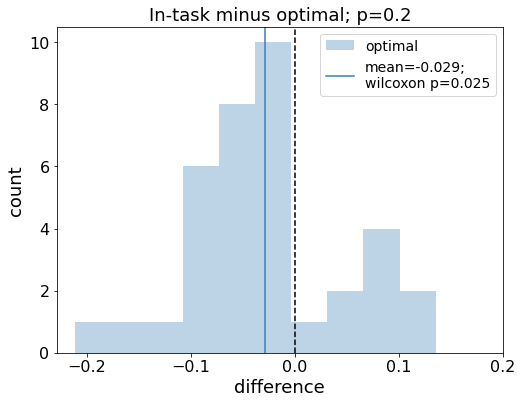

In [383]:
import seaborn as sns
in_minus = accuracies[:,:1] - accuracies[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(8,6))

colors = sns.color_palette("Set1", n_colors=3)

algos = ['oracle', 'optimal']

for i, minus in enumerate(in_minus.T[1:], 1):
    ax.hist(minus[minus != 0], color=colors[i], alpha=0.33, label=algos[i])
    mean=np.mean(minus[minus != 0])
    
    T, p = wilcoxon(minus)
    ax.axvline(x=mean, label='mean=%1.3f;\nwilcoxon p=%1.3f'%(mean,p), c=colors[i])
    
ax.axvline(x=0, c='k', ls='--')
ax.set_title('In-task minus optimal; p=0.2', fontsize=18)
ax.set_xlabel('difference', fontsize=18)
ax.set_ylabel('count', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xticks([-.2, -.1, 0, 0.1, 0.2])
ax.legend(fontsize=14)

In [380]:
p

0.024662604048837574

Text(0.5, 1.0, 'Balanced accuracy paired differences')

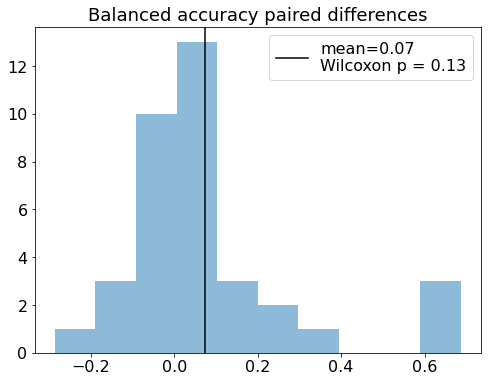

In [210]:
from scipy.stats import wilcoxon

T,p = wilcoxon(bacc_diffs)

mean = np.mean(bacc_diffs)

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.axvline(x=mean, c='k', label='mean=%1.2f\nWilcoxon p = %1.2f'%(mean,p))
ax.hist(bacc_diffs, alpha=0.5)
ax.legend(fontsize=16)

ax.tick_params(labelsize=16)
ax.set_title('Balanced accuracy paired differences', fontsize=18)

In [68]:
from joblib import Parallel, delayed
from tfld import tfld
from tqdm import tqdm

np.random.seed(1)

n_mc = 30
p_list = [0.2, 0.3, 0.5, 0.8]

n_subjects=len(X)
n_sessions=1

y_ = [t.astype(int) % 2 for t in y]

accuracies = np.zeros((len(p_list), n_subjects * n_sessions, 4, n_mc))

for i, p in enumerate(tqdm(p_list)):
    f = lambda x: tfld.experiment(X, y_, p=p)
    
    accuracies[i] = np.array(Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))).transpose((1,2,0))

  0%|                                                                                             | 0/4 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(8,6))

mean_accs = np.mean(accuracies, axis=-1)
std_accs = np.std(np.mean(accuracies, axis=-1), axis=1) / np.sqrt(n_mc * n_subjects * n_sessions)

mean_subj = np.mean(mean_accs, axis=1)

algos = ['in task', 'out task', 'oracle']
colors = sns.color_palette("Set1", n_colors=3)

for i, algo in enumerate(algos):
    ax.errorbar(p_list, mean_subj.T[i], label=algos[i], color=colors[i])
    
ax.legend()
ax.set_yticks([0.5, 0.6, 0.7, 0.8])
ax.set_xticks([0.2, 0.3, 0.5, 0.8])

ax.set_ylabel('accuracy', fontsize=18)
ax.set_xlabel('proportion of in-task data avail.', fontsize=18)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

ax.set_title('Predicting cognitive load with EEG band power', fontsize=18)